In [1]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from bart_playground import *

# Prepare train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize storage for results from 3 different runs
chains_mtmh = []      # Store sigma chains from each run
rmse_chains_mtmh = []  # Store RMSE chains from each run

# Configuration for MultiBART
n_trees = 100
proposal_probs_mtmh = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}

# Run 3 iterations with different random initializations
for run_idx in range(3):
    # Generate different initial trees for each run using different random seeds
    _, _, _, _, random_trees = generate_data_from_defaultbart_prior(
        X=X_train,
        n_trees=n_trees,
        random_state=run_idx,  # Different seed for each run
        return_latent=True
    )
    
    # Create MultiBART model with corresponding random seed and initial trees
    bart_mtmh = MultiBART(
        ndpost=1000, 
        nskip=0, 
        n_trees=n_trees, 
        proposal_probs=proposal_probs_mtmh,
        multi_tries=10, 
        random_state=run_idx,
        init_trees=random_trees
    )
    
    # Fit the model
    bart_mtmh.fit(X_train, y_train)
    
    # Extract sigma chain from the trace
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_mtmh.sampler.trace]
    
    # Generate predictions and calculate RMSE chain
    preds = bart_mtmh.posterior_f(X_test, backtransform=True)
    rmses = [np.sqrt(mean_squared_error(y_test, preds[:, k])) for k in range(preds.shape[1])]
    
    # Store results for this run
    chains_mtmh.append(sigmas)
    rmse_chains_mtmh.append(rmses)

Iterations: 100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


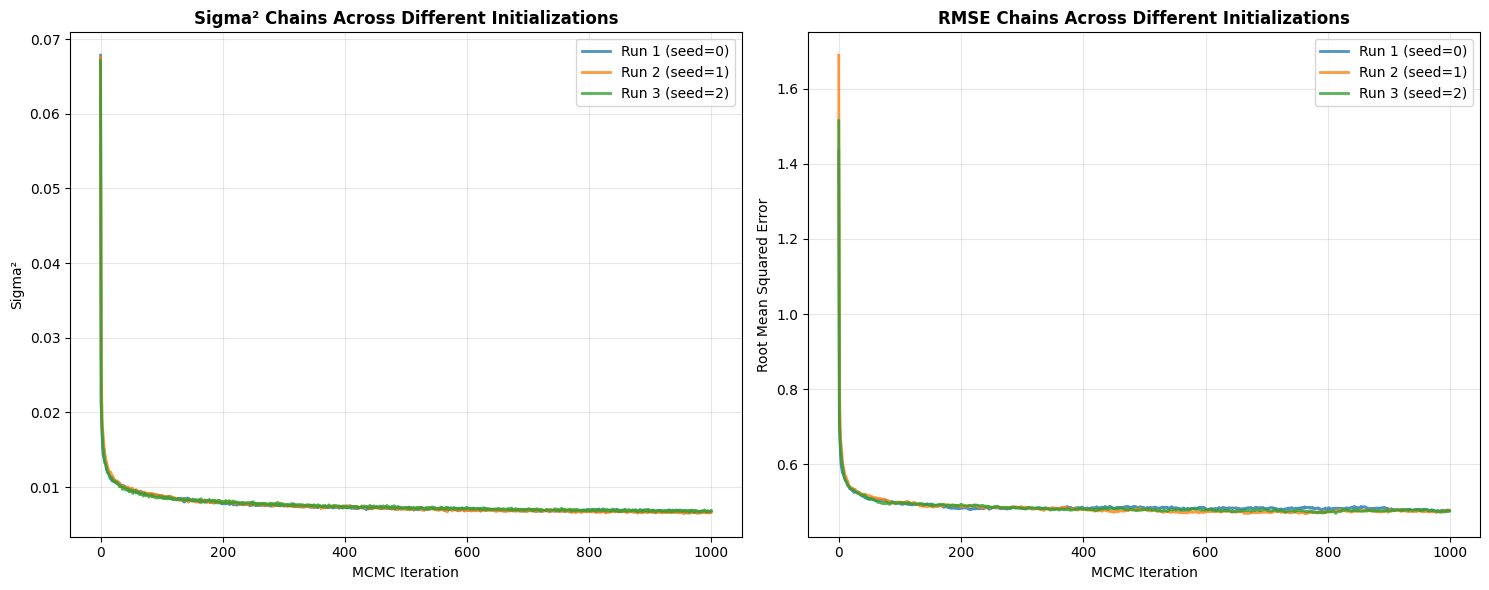

In [3]:
# Plot the results: sigma chains and RMSE chains for all 3 runs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigma² chains
ax1.set_title('Sigma² Chains Across Different Initializations', fontsize=12, fontweight='bold')
for i, sigmas in enumerate(chains_mtmh):
    ax1.plot(sigmas, label=f'Run {i+1} (seed={i})', alpha=0.8, linewidth=2)
ax1.set_xlabel('MCMC Iteration')
ax1.set_ylabel('Sigma²')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot RMSE chains
ax2.set_title('RMSE Chains Across Different Initializations', fontsize=12, fontweight='bold')
for i, rmses in enumerate(rmse_chains_mtmh):
    ax2.plot(rmses, label=f'Run {i+1} (seed={i})', alpha=0.8, linewidth=2)
ax2.set_xlabel('MCMC Iteration')
ax2.set_ylabel('Root Mean Squared Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
chains_mtmh[0][0]

array([0.06784085])

In [7]:
chains_mtmh[1][0]

array([0.06760167])

In [8]:
chains_mtmh[2][0]

array([0.06710707])

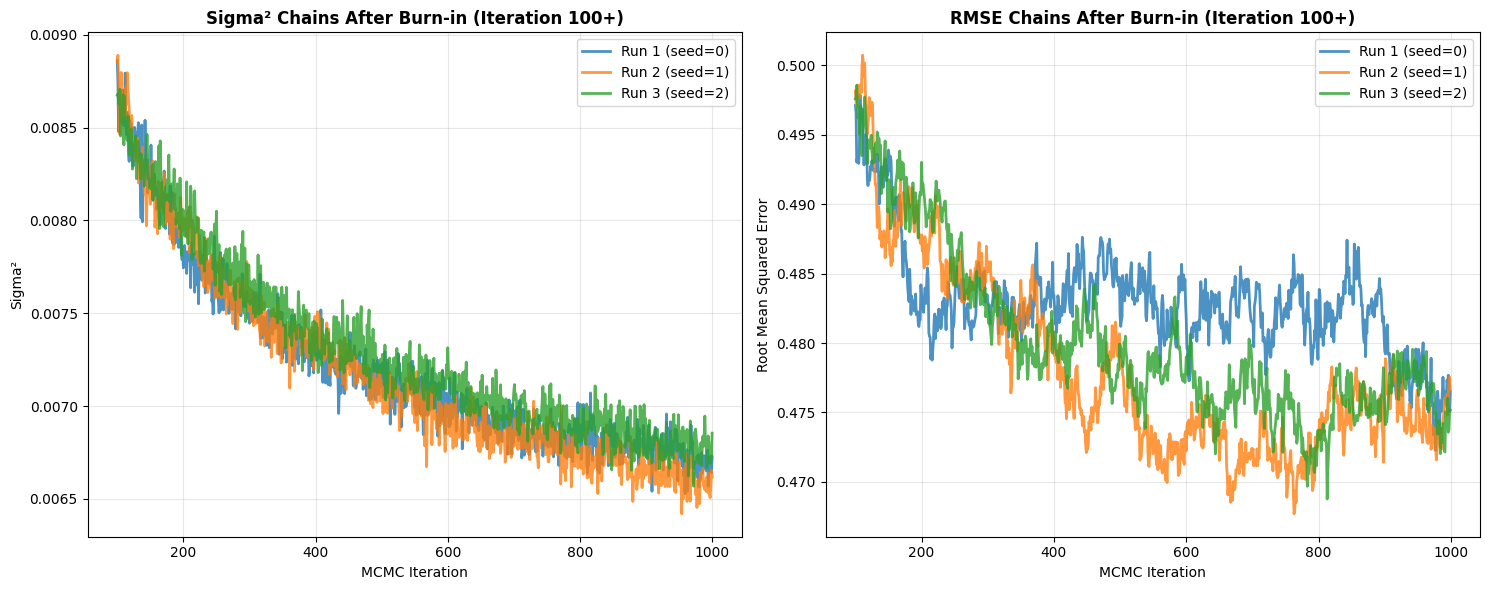

In [9]:
# Plot chains after iteration 100 (burn-in period)
burn_in = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigma² chains after burn-in
ax1.set_title('Sigma² Chains After Burn-in (Iteration 100+)', fontsize=12, fontweight='bold')
for i, sigmas in enumerate(chains_mtmh):
    if len(sigmas) > burn_in:
        ax1.plot(range(burn_in, len(sigmas)), sigmas[burn_in:], 
                label=f'Run {i+1} (seed={i})', alpha=0.8, linewidth=2)
ax1.set_xlabel('MCMC Iteration')
ax1.set_ylabel('Sigma²')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot RMSE chains after burn-in
ax2.set_title('RMSE Chains After Burn-in (Iteration 100+)', fontsize=12, fontweight='bold')
for i, rmses in enumerate(rmse_chains_mtmh):
    if len(rmses) > burn_in:
        ax2.plot(range(burn_in, len(rmses)), rmses[burn_in:], 
                label=f'Run {i+1} (seed={i})', alpha=0.8, linewidth=2)
ax2.set_xlabel('MCMC Iteration')
ax2.set_ylabel('Root Mean Squared Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()